# Analysis of Feature separation in an Auto-Encoder based latent space
#### *Final project - Advanced Deep Learning and Kernel Methods*

*Valentinis Alessio*

## Main goal

The main idea of this project is to regularize the reconstruction loss of an autoencoder with a term that forces latent vectors to stay near given vectors named `centroids`. This regularization can be done via:
- mean of the euclidean distance from the nearest centroid
- mean of the maximum of the softmin of the distances from each centroid (same concept as above, just parametrized in [0,1])
- mean of the minimum of the 1-norm of the distances from each centroid. This last regularization, aiming to reduce globally the various components, should be able to better force *sparse* latent space.

This procedure will be done both with the same number of clusters as the effective classes of the dataset, and with more classes, to see what type of separation is induced and which feature corrisponds to the centroids after training.

### Some useful imports

In [1]:
import torch as th
from model import *
from utils import *

from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.datasets import FashionMNIST

from sklearn.cluster import KMeans
from umap import UMAP

from tqdm import tqdm
from tabulate import tabulate

import matplotlib.pyplot as plt

th.manual_seed(3407)
np.random.seed(3407)

### Defnition of Data Loader and specifics of training

In [2]:
DEVICE = th.device('cuda' if th.cuda.is_available() else 'cpu')
EPOCHS = 80
BATCH_SIZE = 128

In [3]:
# import data
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor()])
train_data = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

---
## 1. Softmin regularization

In [18]:
LATENT_DIM = 10
N_CLUSTERS = 10

In [19]:
model_softmin = ConvAutoencoder(LATENT_DIM).to(DEVICE)
model_custom_softmin = ConvAutoencoder(LATENT_DIM).to(DEVICE)

centroids_softmin = generate_min_potential_vectors(N_CLUSTERS, LATENT_DIM).to(DEVICE)

optimizer = Adam(model_softmin.parameters(), lr=1e-3)
optimizer_custom = Adam(model_custom_softmin.parameters(), lr=1e-3)

In [5]:
model_softmin, model_custom_softmin, centroids_softmin = train_models(EPOCHS, train_loader,
                                                                      model_softmin, optimizer,
                                                                      model_custom_softmin, optimizer_custom, centroids_softmin, l=1e-3,
                                                                      regularization='softmin', device=DEVICE)

save_model(model_softmin, 'models/model_base_softmin.pt')
save_model(model_custom_softmin, 'models/model_custom_softmin.pt')
th.save(centroids_softmin, 'models/centroids_softmin.pt')

100%|██████████| 80/80 [12:33<00:00,  9.42s/it, loss=0.00589, loss_custom=0.00046]


In [20]:
model_softmin = load_model(model_softmin, 'models/model_base_softmin.pt')
model_custom_softmin = load_model(model_custom_softmin, 'models/model_custom_softmin.pt')
centroids_softmin = th.load('models/centroids_softmin.pt', weights_only=True)

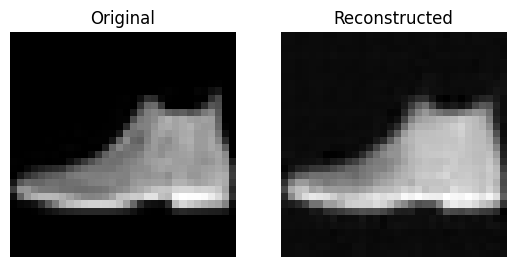

In [26]:
sample, tgt = next(iter(test_loader))
sample = sample.to(DEVICE)
output, encoded = model_custom_softmin(sample)
encoded = encoded.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(sample[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(output[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed')
axs[1].axis('off')

plt.show()

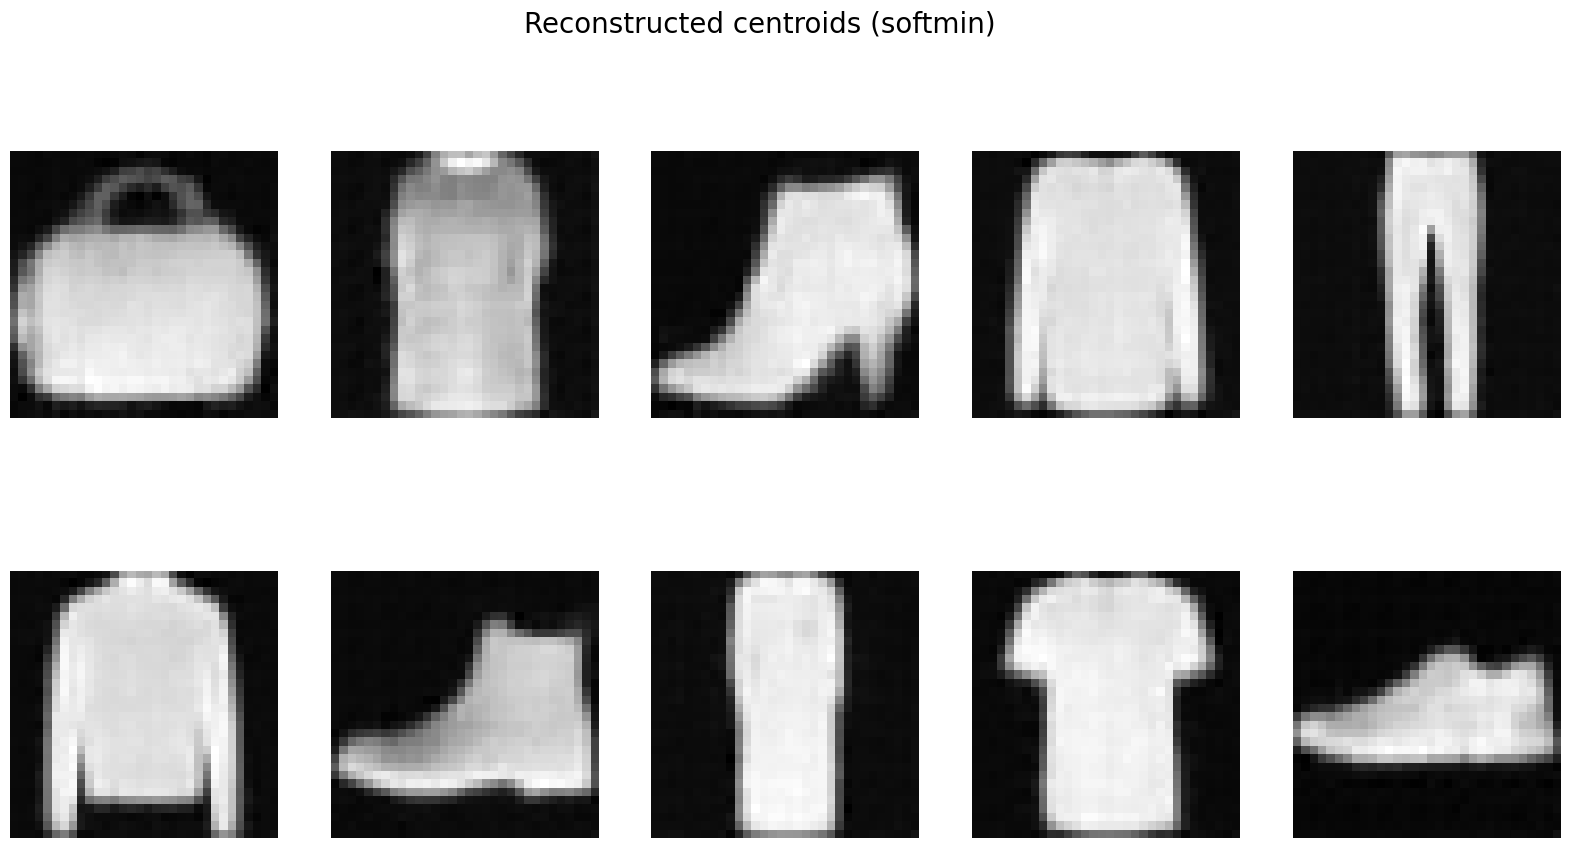

In [27]:
# Try to reconstruct the centroids
model_custom_softmin.eval()
reconstructed = model_custom_softmin.decoder(centroids_softmin).cpu()

fig, axs = plt.subplots(2, N_CLUSTERS//2, figsize=(20, 10))
axs = axs.flatten()

for i in range(N_CLUSTERS):
	axs[i].imshow(reconstructed[i].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
	axs[i].axis('off')

fig.suptitle('Reconstructed centroids (softmin)', fontsize=20)
plt.savefig('imgs/reconstructed_centroids_softmin.png')
plt.show()

In [28]:
centroids = centroids_softmin.cpu().detach().numpy()

umap = UMAP(n_components=3)
encoded = umap.fit_transform(encoded)
centroids = umap.transform(centroids)

labels_dict = {i: str(i) for i in range(10)}
cmap = plt.get_cmap('jet', 10)
color_map = {str(i): f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
             for i, (r, g, b, _) in enumerate(cmap(np.linspace(0, 1, 10)))}

fig = plot_3PC(encoded, tgt, centroids, labels_dict, color_map, title='Fashion-MNIST, 10 clusters, softmin')
fig.show()

In [10]:
kmeans = KMeans(n_clusters=10)
assignments = kmeans.fit_predict(encoded)

# Compute ARI
latent_cl_ari = compute_ARI(tgt, assignments)

# Now on the original space
kmeans = KMeans(n_clusters=10)
assignments = kmeans.fit_predict(test_data.data.view(-1, 28*28))
original_ari = compute_ARI(tgt, assignments)

# print on tabular format
print(tabulate([['Autoencoder', latent_cl_ari], ['Original', original_ari]], headers=['Model', 'ARI'], tablefmt='fancy_grid'))

╒═════════════╤══════════╕
│ Model       │      ARI │
╞═════════════╪══════════╡
│ Autoencoder │ 0.446611 │
├─────────────┼──────────┤
│ Original    │ 0.372457 │
╘═════════════╧══════════╛


### More clusters

In [29]:
N_CLUSTERS = 15
LATENT_DIM = 10

In [30]:
model_softmin = ConvAutoencoder(LATENT_DIM).to(DEVICE)
model_custom_softmin = ConvAutoencoder(LATENT_DIM).to(DEVICE)

centroids_softmin = generate_min_potential_vectors(N_CLUSTERS, LATENT_DIM).to(DEVICE)

optimizer = Adam(model_softmin.parameters(), lr=1e-3)
optimizer_custom = Adam(model_custom_softmin.parameters(), lr=1e-3)

In [13]:
model_softmin, model_custom_softmin, centroids_softmin = train_models(EPOCHS, train_loader,
																	  model_softmin, optimizer,
																	  model_custom_softmin, optimizer_custom, centroids_softmin, l=1e-3,
																	  regulrization='softmin', device=DEVICE)

save_model(model_softmin, 'models/model_base_overcluster_softmin.pt')
save_model(model_custom_softmin, 'models/model_custom_overcluster_softmin.pt')
th.save(centroids_softmin, 'models/centroids_overcluster_softmin.pt')

100%|██████████| 80/80 [13:06<00:00,  9.83s/it, loss=0.0069, loss_custom=-0.00171] 


In [31]:
model_softmin = load_model(model_softmin, 'models/model_base_overcluster_softmin.pt')
model_custom_softmin = load_model(model_custom_softmin, 'models/model_custom_overcluster_softmin.pt')
centroids_softmin = th.load('models/centroids_overcluster_softmin.pt', weights_only=True)

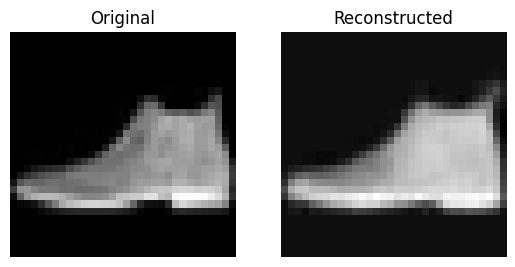

In [32]:
sample, tgt = next(iter(test_loader))
sample = sample.to(DEVICE)
output, encoded = model_custom_softmin(sample)
encoded = encoded.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2)

# sample = sample.view(sample)
# output = output.view(output)

axs[0].imshow(sample[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(output[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed')
axs[1].axis('off')

plt.show()

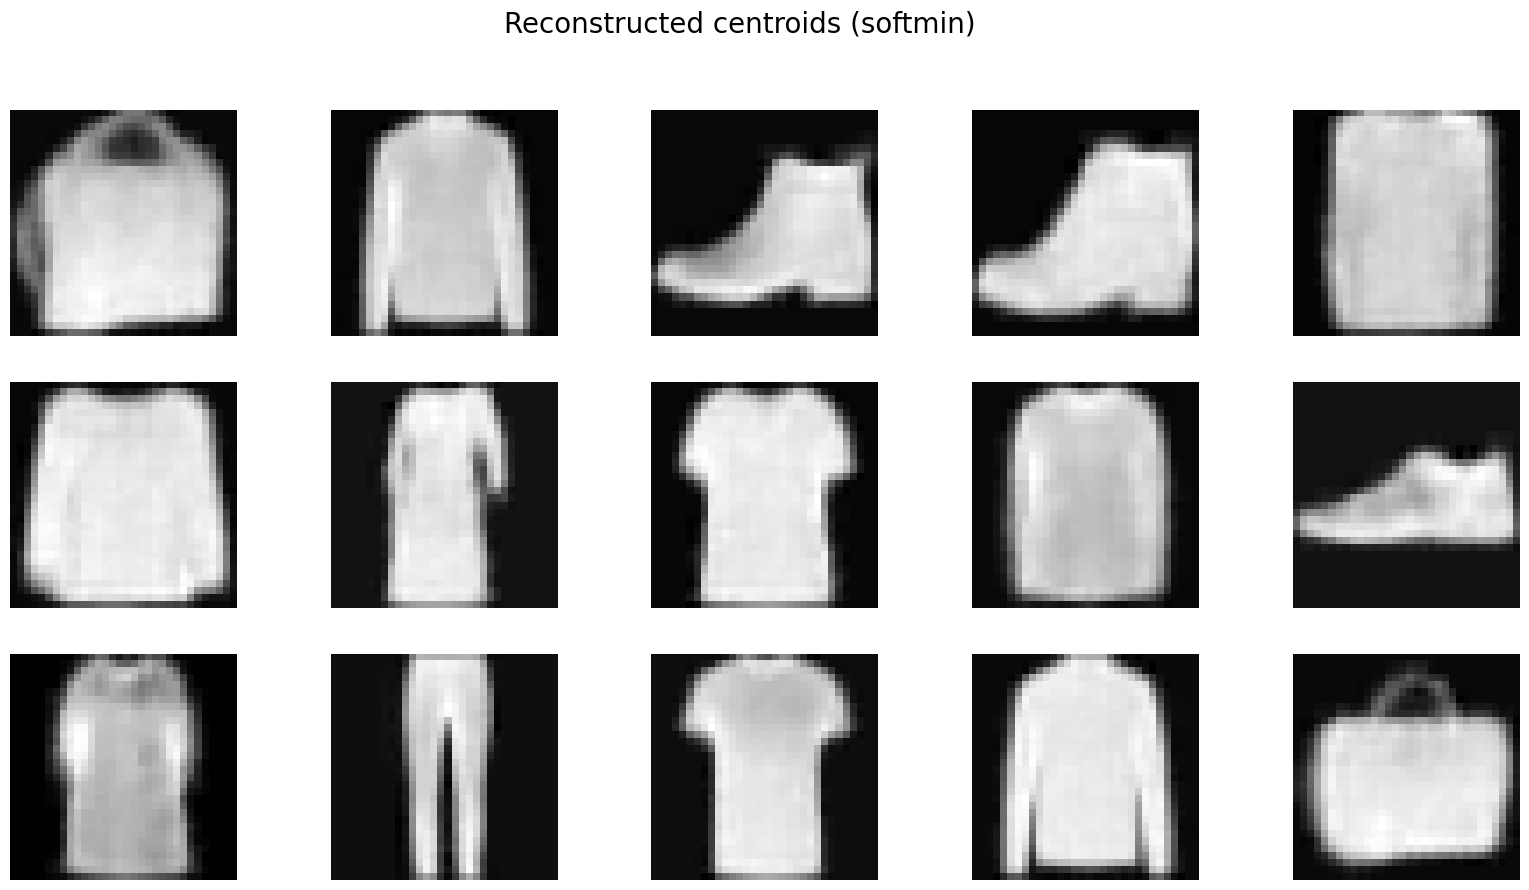

In [33]:
# Try to reconstruct the centroids
model_custom_softmin.eval()
reconstructed = model_custom_softmin.decoder(centroids_softmin).cpu()

fig, axs = plt.subplots(3, N_CLUSTERS//3, figsize=(20, 10))
axs = axs.flatten()

for i in range(N_CLUSTERS):
	axs[i].imshow(reconstructed[i].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
	axs[i].axis('off')

fig.suptitle('Reconstructed centroids (softmin)', fontsize=20)
plt.savefig('imgs/reconstructed_centroids_overcluster_softmin.png')
plt.show()

In [34]:
centroids = centroids_softmin.cpu().detach().numpy()

umap = UMAP(n_components=3)
encoded = umap.fit_transform(encoded)
centroids = umap.transform(centroids)

labels_dict = {i: str(i) for i in range(10)}
cmap = plt.get_cmap('jet', 10)
color_map = {str(i): f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
             for i, (r, g, b, _) in enumerate(cmap(np.linspace(0, 1, 10)))}

fig = plot_3PC(encoded, tgt, centroids, labels_dict, color_map, title='Fashion-MNIST, 15 clusters, softmin')
fig.show()

---
## 2. k-Means regularization

In [35]:
N_CLUSTERS = 10
LATENT_DIM = 10

In [36]:
model_kmeans = ConvAutoencoder(LATENT_DIM).to(DEVICE)
model_custom_kmeans = ConvAutoencoder(LATENT_DIM).to(DEVICE)

centroids_kmeans = generate_min_potential_vectors(N_CLUSTERS, LATENT_DIM).to(DEVICE)

optimizer = Adam(model_kmeans.parameters(), lr=1e-3)
optimizer_custom = Adam(model_custom_kmeans.parameters(), lr=1e-3)

In [20]:
model_kmeans, model_custom_kmeans, centroids_kmeans = train_models(EPOCHS, train_loader,
																	model_kmeans, optimizer,
																	model_custom_kmeans, optimizer_custom, centroids_kmeans, l=1e-3,
																	regulrization='kmeans', device=DEVICE)

save_model(model_kmeans, 'models/model_base_kmeans.pt')
save_model(model_custom_kmeans, 'models/model_custom_kmeans.pt')
th.save(centroids_kmeans, 'models/centroids_kmeans.pt')

100%|██████████| 80/80 [13:50<00:00, 10.38s/it, loss=0.00563, loss_custom=0.00632]


In [37]:
model_kmeans = load_model(model_kmeans, 'models/model_base_kmeans.pt')
model_custom_kmeans = load_model(model_custom_kmeans, 'models/model_custom_kmeans.pt')
centroids_kmeans = th.load('models/centroids_kmeans.pt', weights_only=True)

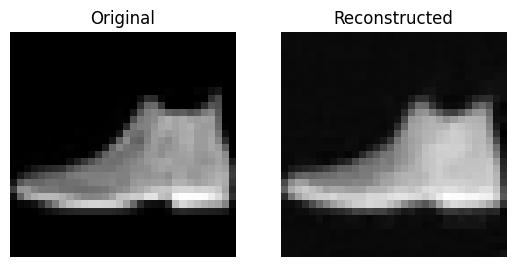

In [38]:
sample, tgt = next(iter(test_loader))
sample = sample.to(DEVICE)
output, encoded = model_custom_kmeans(sample)
encoded = encoded.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2)

# sample = sample.view(sample)
# output = output.view(output)

axs[0].imshow(sample[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(output[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed')
axs[1].axis('off')

plt.show()

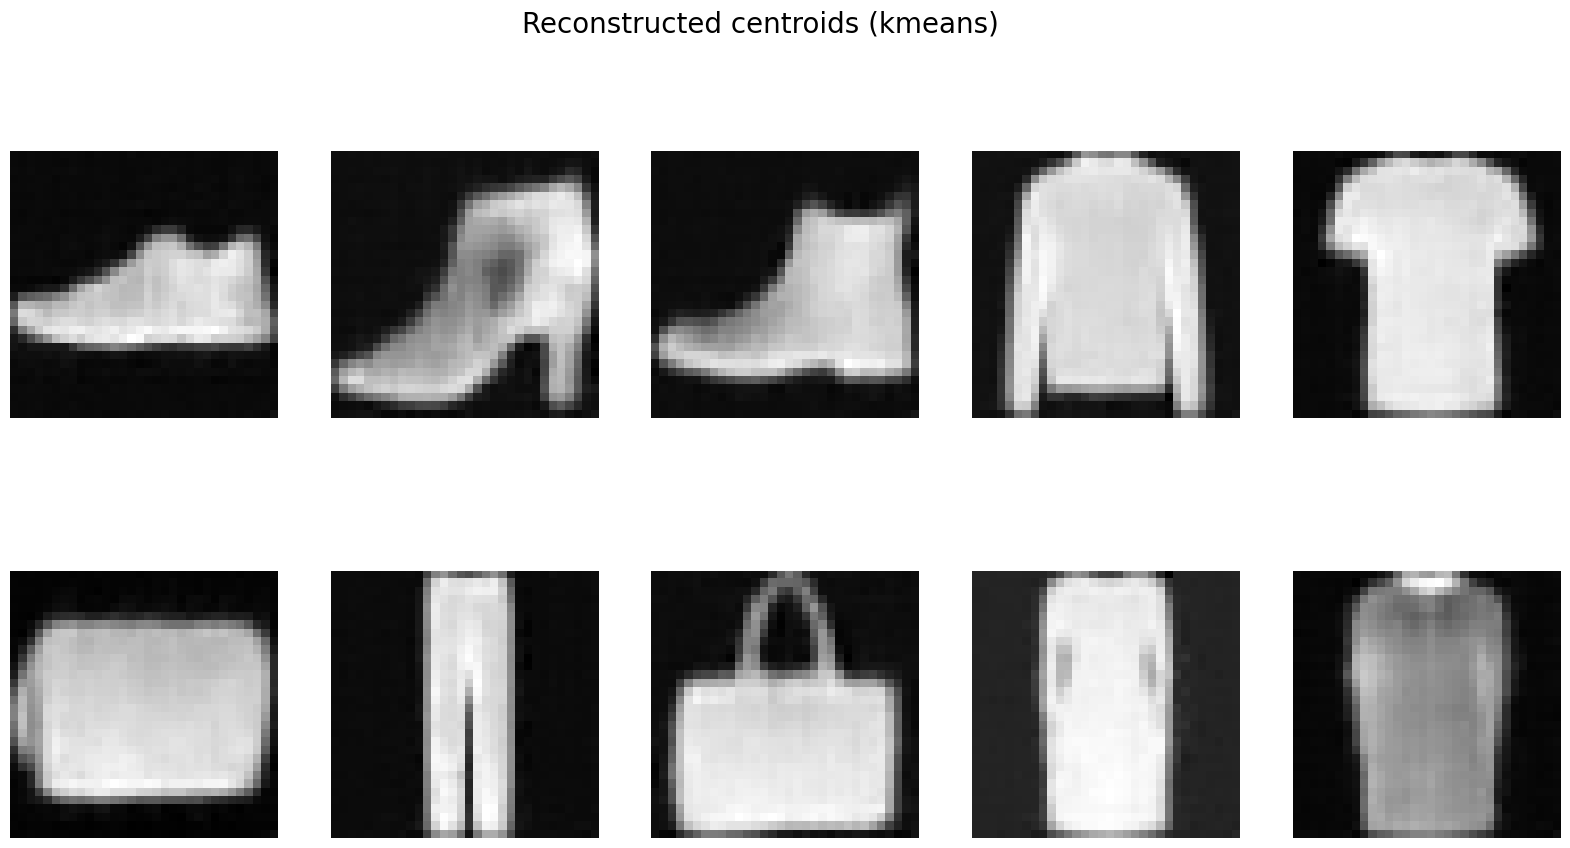

In [39]:
# Try to reconstruct the centroids
model_custom_kmeans.eval()
reconstructed = model_custom_kmeans.decoder(centroids_kmeans).cpu()

fig, axs = plt.subplots(2, N_CLUSTERS//2, figsize=(20, 10))
axs = axs.flatten()

for i in range(N_CLUSTERS):
	axs[i].imshow(reconstructed[i].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
	axs[i].axis('off')

fig.suptitle('Reconstructed centroids (kmeans)', fontsize=20)
plt.savefig('imgs/reconstructed_centroids_kmeans.png')
plt.show()

In [40]:
from umap import UMAP

centroids = centroids_kmeans.cpu().detach().numpy()

umap = UMAP(n_components=3)
encoded = umap.fit_transform(encoded)
centroids = umap.transform(centroids)

labels_dict = {i: str(i) for i in range(10)}
cmap = plt.get_cmap('jet', 10)
color_map = {str(i): f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
             for i, (r, g, b, _) in enumerate(cmap(np.linspace(0, 1, 10)))}

fig = plot_3PC(encoded, tgt, centroids, labels_dict, color_map, title='Fashion-MNIST, 10 clusters, kmeans')
fig.show()

In [25]:
kmeans = KMeans(n_clusters=10)
assignments = kmeans.fit_predict(encoded)

# Compute ARI
latent_cl_ari = compute_ARI(tgt, assignments)

# Now on the original space
kmeans = KMeans(n_clusters=10)
assignments = kmeans.fit_predict(test_data.data.view(-1, 28*28))
original_ari = compute_ARI(tgt, assignments)

# print on tabular format
print(tabulate([['Autoencoder', latent_cl_ari], ['Original', original_ari]], headers=['Model', 'ARI'], tablefmt='fancy_grid'))

╒═════════════╤══════════╕
│ Model       │      ARI │
╞═════════════╪══════════╡
│ Autoencoder │ 0.495157 │
├─────────────┼──────────┤
│ Original    │ 0.408794 │
╘═════════════╧══════════╛


### More clusters

In [41]:
N_CLUSTERS = 15
LATENT_DIM = 10

In [42]:
model_kmeans = ConvAutoencoder(LATENT_DIM).to(DEVICE)
model_custom_kmeans = ConvAutoencoder(LATENT_DIM).to(DEVICE)

centroids_kmeans = generate_min_potential_vectors(N_CLUSTERS, LATENT_DIM).to(DEVICE)

optimizer = Adam(model_kmeans.parameters(), lr=1e-3)
optimizer_custom = Adam(model_custom_kmeans.parameters(), lr=1e-3)

In [28]:
model_kmeans, model_custom_kmeans, centroids_kmeans = train_models(EPOCHS, train_loader,
																	model_kmeans, optimizer,
																	model_custom_kmeans, optimizer_custom, centroids_kmeans, l=1e-3,
																	regulrization='kmeans', device=DEVICE)

save_model(model_kmeans, 'models/model_base_overcluster_kmeans.pt')
save_model(model_custom_kmeans, 'models/model_custom_overcluster_kmeans.pt')
th.save(centroids_kmeans, 'models/centroids_overcluster_kmeans.pt')

100%|██████████| 80/80 [13:53<00:00, 10.42s/it, loss=0.00675, loss_custom=0.00787]


In [43]:
model_kmeans = load_model(model_kmeans, 'models/model_base_overcluster_kmeans.pt')
model_custom_kmeans = load_model(model_custom_kmeans, 'models/model_custom_overcluster_kmeans.pt')
centroids_kmeans = th.load('models/centroids_overcluster_kmeans.pt', weights_only=True)

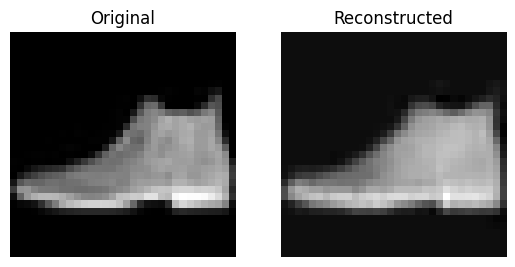

In [44]:
sample, tgt = next(iter(test_loader))
sample = sample.to(DEVICE)
output, encoded = model_custom_kmeans(sample)
encoded = encoded.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2)

# sample = sample.view(sample)
# output = output.view(output)

axs[0].imshow(sample[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(output[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed')
axs[1].axis('off')

plt.show()

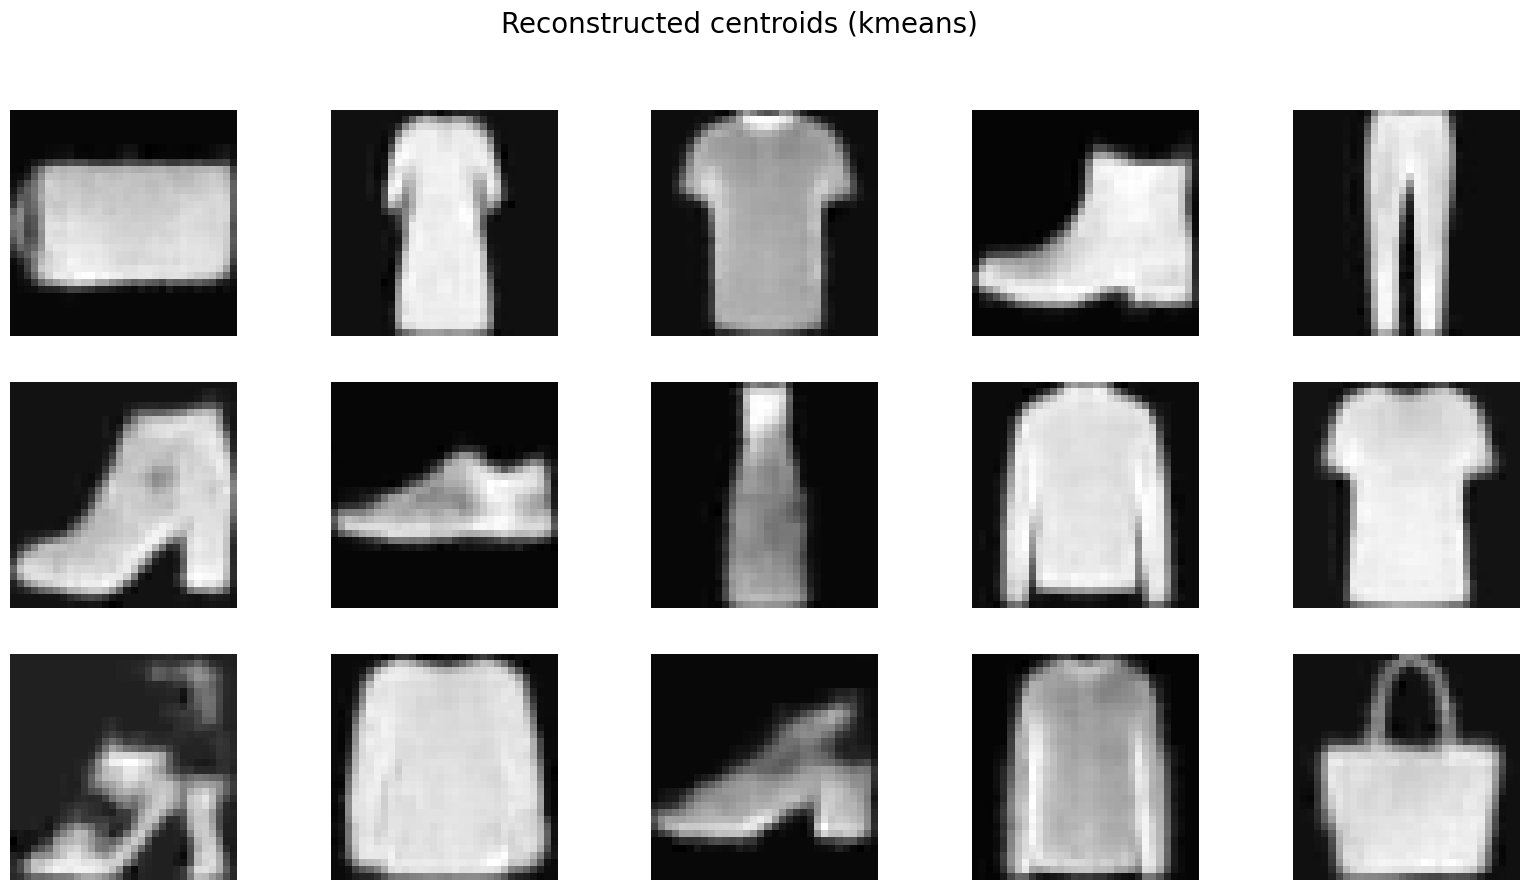

In [45]:
# Try to reconstruct the centroids
model_custom_kmeans.eval()
reconstructed = model_custom_kmeans.decoder(centroids_kmeans).cpu()

fig, axs = plt.subplots(3, N_CLUSTERS//3, figsize=(20, 10))
axs = axs.flatten()

for i in range(N_CLUSTERS):
	axs[i].imshow(reconstructed[i].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
	axs[i].axis('off')

fig.suptitle('Reconstructed centroids (kmeans)', fontsize=20)
plt.savefig('imgs/reconstructed_centroids_overcluster_kmeans.png')
plt.show()

In [46]:
centroids = centroids_kmeans.cpu().detach().numpy()

umap = UMAP(n_components=3)
encoded = umap.fit_transform(encoded)
centroids = umap.transform(centroids)

labels_dict = {i: str(i) for i in range(10)}
cmap = plt.get_cmap('jet', 10)
color_map = {str(i): f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
             for i, (r, g, b, _) in enumerate(cmap(np.linspace(0, 1, 10)))}

fig = plot_3PC(encoded, tgt, centroids, labels_dict, color_map, title='Fashion-MNIST, 15 clusters, kmeans')
fig.show()

---
## 3. 1-norm regularization

In [47]:
N_CLUSTERS = 10
LATENT_DIM = 10

In [48]:
model_1norm = ConvAutoencoder(LATENT_DIM).to(DEVICE)
model_custom_1norm = ConvAutoencoder(LATENT_DIM).to(DEVICE)

centroids_1norm = generate_min_potential_vectors(N_CLUSTERS, LATENT_DIM).to(DEVICE)

optimizer = Adam(model_1norm.parameters(), lr=1e-3)
optimizer_custom = Adam(model_custom_1norm.parameters(), lr=1e-3)

In [35]:
model_1norm, model_custom_1norm, centroids_1norm = train_models(EPOCHS, train_loader,
																  model_1norm, optimizer,
																  model_custom_1norm, optimizer_custom, centroids_1norm, l=1e-5,
																  regulrization='norm', device=DEVICE)

save_model(model_1norm, 'models/model_base_1norm.pt')
save_model(model_custom_1norm, 'models/model_custom_1norm.pt')
th.save(centroids_1norm, 'models/centroids_1norm.pt')

100%|██████████| 80/80 [13:51<00:00, 10.39s/it, loss=0.00569, loss_custom=0.00605]


In [49]:
model_1norm = load_model(model_1norm, 'models/model_base_1norm.pt')
model_custom_1norm = load_model(model_custom_1norm, 'models/model_custom_1norm.pt')
centroids_1norm = th.load('models/centroids_1norm.pt', weights_only=True)

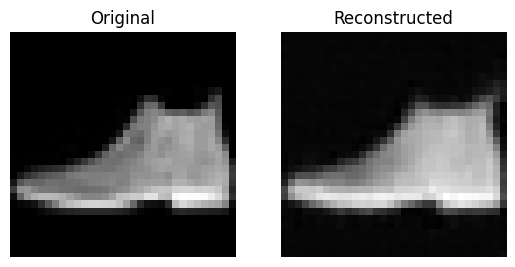

In [50]:
sample, tgt = next(iter(test_loader))
sample = sample.to(DEVICE)
output, encoded = model_custom_1norm(sample)
encoded = encoded.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2)

# sample = sample.view(sample)
# output = output.view(output)

axs[0].imshow(sample[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(output[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed')
axs[1].axis('off')

plt.show()

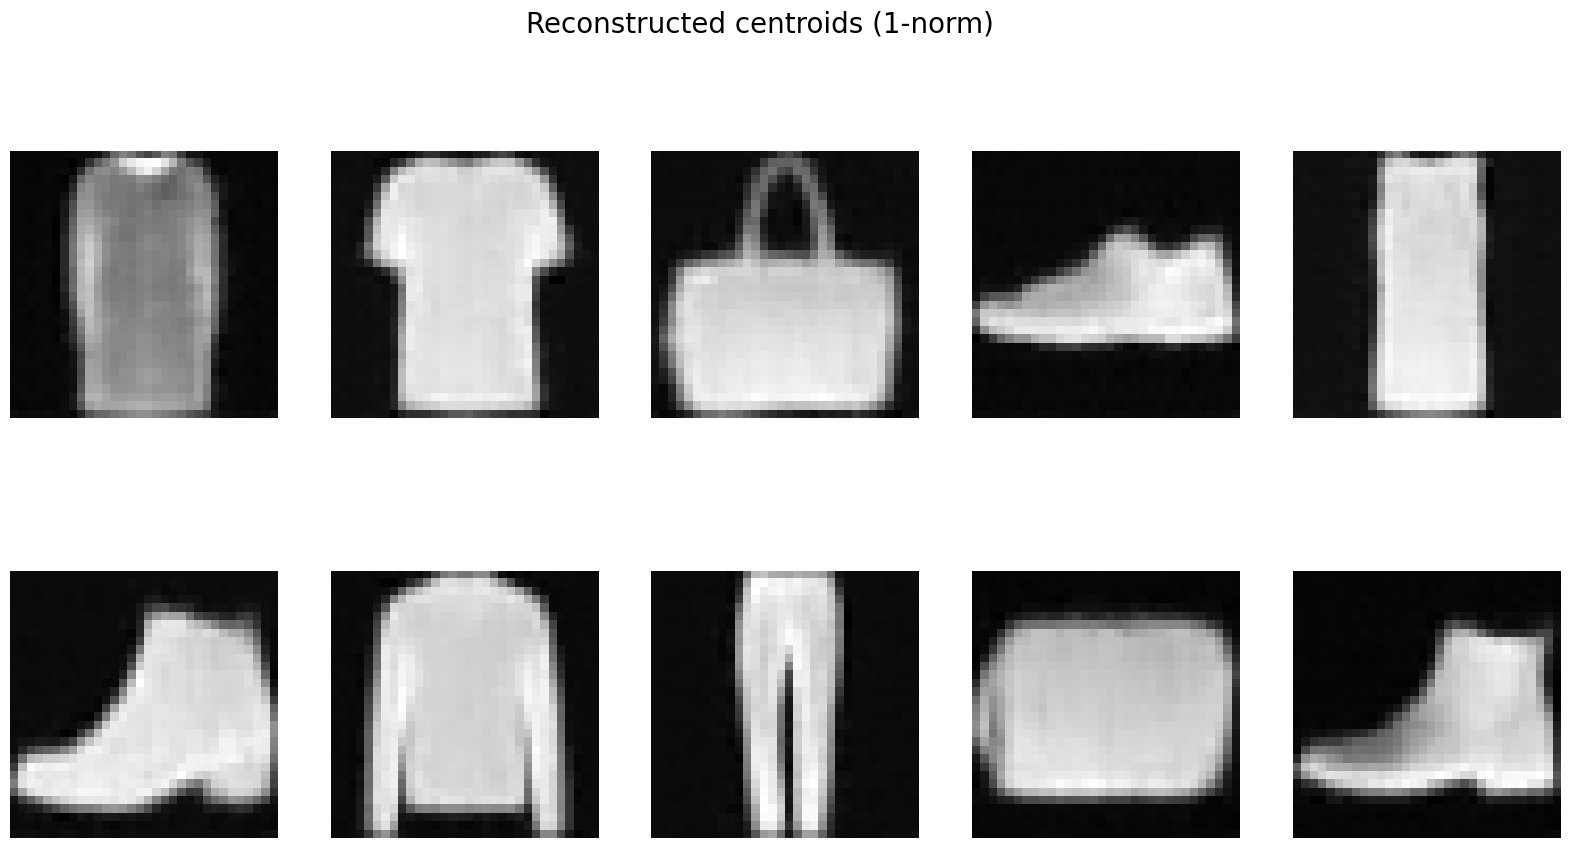

In [51]:
# Try to reconstruct the centroids
model_custom_1norm.eval()
reconstructed = model_custom_1norm.decoder(centroids_1norm).cpu()

fig, axs = plt.subplots(2, N_CLUSTERS//2, figsize=(20, 10))
axs = axs.flatten()

for i in range(N_CLUSTERS):
	axs[i].imshow(reconstructed[i].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
	axs[i].axis('off')

fig.suptitle('Reconstructed centroids (1-norm)', fontsize=20)
plt.savefig('imgs/reconstructed_centroids_1norm.png')
plt.show()

In [52]:
centroids = centroids_1norm.cpu().detach().numpy()

umap = UMAP(n_components=3)
encoded = umap.fit_transform(encoded)
centroids = umap.transform(centroids)

labels_dict = {i: str(i) for i in range(10)}
cmap = plt.get_cmap('jet', 10)
color_map = {str(i): f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
             for i, (r, g, b, _) in enumerate(cmap(np.linspace(0, 1, 10)))}

fig = plot_3PC(encoded, tgt, centroids, labels_dict, color_map, title='Fashion-MNIST, 10 clusters, 1-norm')
fig.show()

In [40]:
kmeans = KMeans(n_clusters=10)
assignments = kmeans.fit_predict(encoded)

# Compute ARI
latent_cl_ari = compute_ARI(tgt, assignments)

# Now on the original space
kmeans = KMeans(n_clusters=10)
assignments = kmeans.fit_predict(test_data.data.view(-1, 28*28))
original_ari = compute_ARI(tgt, assignments)

# print on tabular format
print(tabulate([['Autoencoder', latent_cl_ari], ['Original', original_ari]], headers=['Model', 'ARI'], tablefmt='fancy_grid'))

╒═════════════╤══════════╕
│ Model       │      ARI │
╞═════════════╪══════════╡
│ Autoencoder │ 0.477873 │
├─────────────┼──────────┤
│ Original    │ 0.334803 │
╘═════════════╧══════════╛


### More clusters

In [53]:
N_CLUSTERS = 15
LATENT_DIM = 10

In [54]:
model_1norm = ConvAutoencoder(LATENT_DIM).to(DEVICE)
model_custom_1norm = ConvAutoencoder(LATENT_DIM).to(DEVICE)

centroids_1norm = generate_min_potential_vectors(N_CLUSTERS, LATENT_DIM).to(DEVICE)

optimizer = Adam(model_1norm.parameters(), lr=1e-3)
optimizer_custom = Adam(model_custom_1norm.parameters(), lr=1e-3)

In [43]:
model_1norm, model_custom_1norm, centroids_1norm = train_models(EPOCHS, train_loader,
																  model_1norm, optimizer,
																  model_custom_1norm, optimizer_custom, centroids_1norm, l=1e-5,
																  regulrization='norm', device=DEVICE)

save_model(model_1norm, 'models/model_base_overcluster_1norm.pt')
save_model(model_custom_1norm, 'models/model_custom_overcluster_1norm.pt')
th.save(centroids_1norm, 'models/centroids_overcluster_1norm.pt')

100%|██████████| 80/80 [14:01<00:00, 10.52s/it, loss=0.00695, loss_custom=0.00759]


In [55]:
model_1norm = load_model(model_1norm, 'models/model_base_overcluster_1norm.pt')
model_custom_1norm = load_model(model_custom_1norm, 'models/model_custom_overcluster_1norm.pt')
centroids_1norm = th.load('models/centroids_overcluster_1norm.pt', weights_only=True)

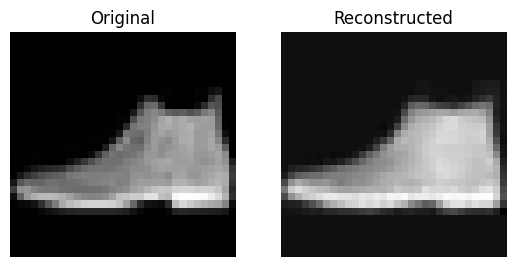

In [56]:
sample, tgt = next(iter(test_loader))
sample = sample.to(DEVICE)
output, encoded = model_custom_1norm(sample)
encoded = encoded.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2)

# sample = sample.view(sample)
# output = output.view(output)

axs[0].imshow(sample[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(output[0].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed')
axs[1].axis('off')

plt.show()

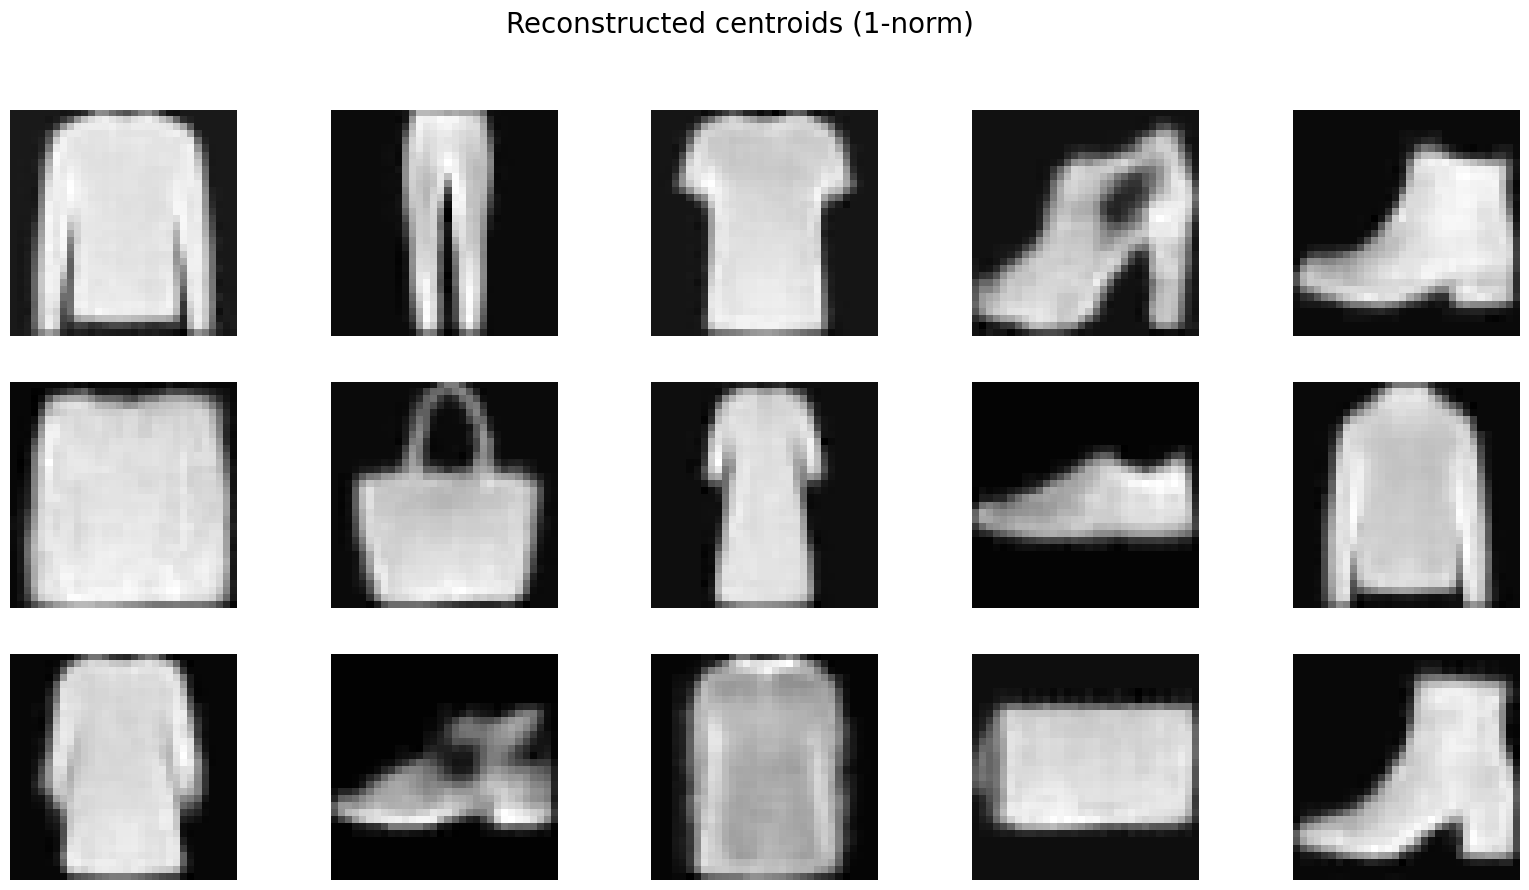

In [58]:
# Try to reconstruct the centroids
model_custom_1norm.eval()
reconstructed = model_custom_1norm.decoder(centroids_1norm).cpu()

fig, axs = plt.subplots(3, N_CLUSTERS//3, figsize=(20, 10))
axs = axs.flatten()

for i in range(N_CLUSTERS):
	axs[i].imshow(reconstructed[i].permute(1,2,0).squeeze().cpu().detach().numpy(), cmap='gray')
	axs[i].axis('off')

fig.suptitle('Reconstructed centroids (1-norm)', fontsize=20)
plt.savefig('imgs/reconstructed_centroids_overcluster_1norm.png')
plt.show()

In [59]:
centroids = centroids_1norm.cpu().detach().numpy()

umap = UMAP(n_components=3)
encoded = umap.fit_transform(encoded)
centroids = umap.transform(centroids)

labels_dict = {i: str(i) for i in range(10)}
cmap = plt.get_cmap('jet', 10)
color_map = {str(i): f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
             for i, (r, g, b, _) in enumerate(cmap(np.linspace(0, 1, 10)))}

fig = plot_3PC(encoded, tgt, centroids, labels_dict, color_map, title='Fashion-MNIST, 15 clusters, 1-norm')
fig.show()